# 3. Pipeline 효율적 실행을 위한 추가 기능 실습: Step Caching / Selective Execution

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

---

The flow of this notebook is as follows,
- [Download Dataset](#Download-Dataset)
- [Define a New Pipeline](#Define-a-New-Pipeline) (+ step_cache)
    - [Setup](#Setup)
    - [PreProcessing](#PreProcessing)
    - [Train](#Train)
    - [Evaluation](#Evaluation)
    - [Create Model](#Create-Model)
    - [Register Model](#Register-Model)
    - [Conditional Check](#Conditional-Check)
- [Execute Pipeline](#Execute-Pipeline)
- [Selective Execution](#Selective-Execution)
    - [Setup](#Setup)
    - [Selective Execution Scenarios](#Selective-Execution-Scenarios)
        - [Execute Single Pipeline Step with Changes to Parameters](#Execute-Single-Pipeline-Step-with-Changes-to-Parameters)
        - [Execute Multiple Contiguous Pipeline Steps or the Entire Pipeline Manually](#Execute-Multiple-Contiguous-Pipeline-Steps-or-the-Entire-Pipeline-Manually)

In [1]:
#!python3 -m pip install -U sagemaker==2.162.0

In [2]:
import boto3
import pprint
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()
sm_client = boto3.client("sagemaker")
s3 = boto3.resource("s3")
model_package_group_name = "Abalone-Models"

# Download Dataset 

In [4]:
!mkdir -p raw-data/

In [5]:
s3.Bucket(f"sagemaker-example-files-prod-{region}").download_file(
    "datasets/tabular/uci_abalone/abalone.csv", "raw-data/abalone.csv"
)

In [6]:
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path="raw-data/abalone.csv",
    desired_s3_uri=f"s3://{default_bucket}/sample-dataset/abalone",
)
print(input_data_uri)

s3://sagemaker-us-east-1-211125368524/sample-dataset/abalone/abalone.csv


# Define a New Pipeline

## Setup

In [7]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)
from sagemaker.workflow.steps import CacheConfig

Lets define parameters which would be leveraged throught our pipeline, we can change these parameters during execution and control various aspects of our pipeline

In [8]:
step_cache_config = CacheConfig(
    enable_caching=True,
    expire_after="T12H",
)
# processing params
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.c5.xlarge"
)
# training params
train_instance_count = ParameterInteger(name="TrainingInstanceCount", default_value=1)
train_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.c5.xlarge")

xgb_num_round = ParameterInteger(name="XGBNumRounds", default_value=50)
xgb_max_depth = ParameterInteger(name="XGBMaxDepth", default_value=5)
xgb_eta = ParameterFloat(name="XGBETA", default_value=0.2)
xgb_gamma = ParameterInteger(name="XGBGamma", default_value=4)
xgb_min_child_weight = ParameterInteger(name="XGBMinChildWeight", default_value=6)
xgb_subsample = ParameterFloat(name="XGBSubSample", default_value=0.7)

# model params
model_path = ParameterString(
    name="ModelPath", default_value=f"s3://{default_bucket}/Abalone/models/"
)

default_model_status = ParameterString(name="ApprovalStatus", default_value="PendingManualApproval")

input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)

threshold = ParameterFloat(name="MseThreshold", default_value=6.0)

## PreProcessing 

In [9]:
!mkdir -p code_04

In [10]:
%%writefile code_04/preprocessing.py

import os
os.system('python3 -m pip install -U sagemaker')

import boto3
import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sagemaker.session import Session
from sagemaker.experiments.run import Run, load_run

session = Session(boto3.session.Session(region_name="us-east-1"))


def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z


def read_parameters():
    """
    Read job parameters
    Returns:
        (Namespace): read parameters
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_size', type=float, default=0.7)
    parser.add_argument('--val_size', type=float, default=0.2)
    parser.add_argument('--test_size', type=float, default=0.1)
    parser.add_argument('--random_state', type=int, default=10)
    parser.add_argument('--cat_feature_cols', type=str, default="sex")
    parser.add_argument('--num_feature_cols', type=str, default="length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight")
    parser.add_argument('--target_col', type=str, default="rings")
    parser.add_argument('--input_path', type=str, default="/opt/ml/processing/input")
    parser.add_argument('--input_filename', type=str, default="abalone.csv")
    parser.add_argument('--output_path_train', type=str, default="/opt/ml/processing/output/train")
    parser.add_argument('--output_path_validation', type=str, default="/opt/ml/processing/output/validation")
    parser.add_argument('--output_path_test', type=str, default="/opt/ml/processing/output/test")
    params, _ = parser.parse_known_args()
    return params


if __name__ == "__main__":
    
    # reading job parameters
    args = read_parameters()

    df = pd.read_csv(
        os.path.join(args.input_path, args.input_filename),
        header=None,
        names=f"{args.cat_feature_cols},{args.num_feature_cols},{args.target_col}".split(',')
    )

    numeric_features = args.num_feature_cols.split(',')
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    categorical_features = args.cat_feature_cols.split(',')
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    y = df.pop("rings")
    X_pre = preprocess.fit_transform(df)
    y_pre = y.to_numpy().reshape(len(y), 1)

    X = np.concatenate((y_pre, X_pre), axis=1)

    train, test = train_test_split(
        X,  
        test_size=args.test_size, 
        random_state=args.random_state
    )

    train, validation  = train_test_split(
        train,
        test_size=args.val_size, 
        random_state=args.random_state
    )

    pd.DataFrame(train).to_csv(
        os.path.join(
            args.output_path_train, 
            "train.csv"
        ), 
        header=False, 
        index=False
    )
    pd.DataFrame(validation).to_csv(
        os.path.join(
            args.output_path_validation, 
            "validation.csv"
        ), 
        header=False, 
        index=False
    )

    pd.DataFrame(test).to_csv(
        os.path.join(
            args.output_path_test, 
            "test.csv"
        ), 
        header=False, 
        index=False
    )

    print("Done")

Overwriting code_04/preprocessing.py


In [11]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

In [12]:
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="abalone-preprocess",
    role=role,
    sagemaker_session=pipeline_session,
)

The input argument instance_type of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is interpreted in pipeline execution time only. As the function needs to evaluate the argument value in SDK compile time, the default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.


In [13]:
processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/output/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/output/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/output/test"),
    ],
    code="code_04/preprocessing.py",
    arguments=[
        "--train_size",
        str(0.7),
        "--val_size",
        str(0.2),
        "--test_size",
        str(0.1),
        "--random_state",
        str(10),
        "--cat_feature_cols",
        "sex",
        "--num_feature_cols",
        "length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight",
        "--target_col",
        "rings",
    ],
)

step_preprocess = ProcessingStep(
    name="Abalone-Preprocess", step_args=processor_args, cache_config=step_cache_config
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


## Train

In [14]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

In [15]:
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=train_instance_type.default_value,
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_count=train_instance_count,
    output_path=model_path,
    base_job_name="abalone-train",
    instance_type=train_instance_type.default_value,
    role=role,
    sagemaker_session=pipeline_session,
)
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=xgb_num_round,
    max_depth=xgb_max_depth,
    eta=xgb_eta,
    gamma=xgb_gamma,
    min_child_weight=xgb_gamma,
    subsample=xgb_subsample,
)

In [16]:
train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_preprocess.properties.ProcessingOutputConfig.Outputs[
                "train"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_preprocess.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

step_train = TrainingStep(
    name="Abalone-Train", step_args=train_args, cache_config=step_cache_config
)

## Evaluation

In [17]:
%%writefile code_04/evaluation.py

import os
os.system('python3 -m pip install -U sagemaker xgboost==1.0.1 scikit-learn')

import glob
import boto3
import json
import pathlib
import pickle
import tarfile
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
import xgboost
import argparse

from sklearn.metrics import mean_squared_error

from sagemaker.session import Session
from sagemaker.experiments.run import Run, load_run

session = Session(boto3.session.Session(region_name="us-east-1"))


def read_parameters():
    """
    Read job parameters
    Returns:
        (Namespace): read parameters
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str, default="/opt/ml/processing/model")
    parser.add_argument('--test_csv', type=str, default="/opt/ml/processing/output/test")
    parser.add_argument('--output_path', type=str, default="/opt/ml/processing/evaluation")
    params, _ = parser.parse_known_args()
    return params


if __name__ == "__main__":
    
    # reading job parameters
    args = read_parameters()
    
    available_model = glob.glob(os.path.join(args.model_path, "*.tar.gz"))
    assert len(available_model) == 1, f"multiple tar gz models found in models dir: {available_model}"
    print(f"Model found: {available_model}")
    model_path = available_model[0]

    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = os.path.join(args.test_csv, "test.csv")
    df = pd.read_csv(test_path, header=None)

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgboost.DMatrix(df.values)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {"value": mse, "standard_deviation": std},
        }
    }
    
    print(report_dict)

    output_dir = args.output_path
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))
    
    print("Done")

Overwriting code_04/evaluation.py


In [18]:
from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.properties import PropertyFile

In [19]:
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    volume_size_in_gb=10,
    instance_count=1,
    base_job_name="abalone-postproc",
    role=role,
    sagemaker_session=pipeline_session,
)

In [20]:
eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_preprocess.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/output/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code_04/evaluation.py",
)

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

step_eval = ProcessingStep(
    name="Abalone-Evaluate",
    step_args=eval_args,
    cache_config=step_cache_config,
    property_files=[evaluation_report],
)

## Create Model

In [21]:
from sagemaker.model import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

In [22]:
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

In [23]:
step_create_model = ModelStep(
    name="Abalone-CreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

## Register Model

In [24]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

In [25]:
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

In [26]:
register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=default_model_status,
    model_metrics=model_metrics,
)

step_register = ModelStep(name="Abalone-ModelRegister", step_args=register_args)

## Conditional Check

In [27]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

In [28]:
step_fail = FailStep(
    name="Abalone-FailNotify",
    error_message=Join(on=" ", values=["Execution failed due to MSE >", threshold]),
)

cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.mse.value",
    ),
    right=threshold,
)

In [29]:
step_cond = ConditionStep(
    name="Abalone-MSECheck",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model],
    else_steps=[step_fail],
)

# Execute Pipeline

In [52]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.workflow.pipeline import PipelineExperimentConfig

In [62]:
experiment_name = "AbaloneExperimentsPipeline"

# Pipeline experiment config
abalone_experiments_config = PipelineExperimentConfig(
    experiment_name, ExecutionVariables.PIPELINE_EXECUTION_ID
)

In [75]:
pipeline_name = "AbalonePipeline-SelectExec"

pipeline = Pipeline(
    name=pipeline_name,
    pipeline_experiment_config=abalone_experiments_config,
    parameters=[
        processing_instance_count,
        processing_instance_type,
        train_instance_count,
        train_instance_type,
        xgb_num_round,
        xgb_max_depth,
        xgb_eta,
        xgb_gamma,
        xgb_min_child_weight,
        xgb_subsample,
        model_path,
        default_model_status,
        input_data,
        threshold,
    ],
    steps=[step_preprocess, step_train, step_eval, step_cond],
    sagemaker_session=pipeline_session,
)

In [76]:
import json

definition = json.loads(pipeline.definition())
definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceCount',
   'Type': 'Integer',
   'DefaultValue': 1},
  {'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c5.xlarge'},
  {'Name': 'TrainingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c5.xlarge'},
  {'Name': 'XGBNumRounds', 'Type': 'Integer', 'DefaultValue': 50},
  {'Name': 'XGBMaxDepth', 'Type': 'Integer', 'DefaultValue': 5},
  {'Name': 'XGBETA', 'Type': 'Float', 'DefaultValue': 0.2},
  {'Name': 'XGBGamma', 'Type': 'Integer', 'DefaultValue': 4},
  {'Name': 'XGBMinChildWeight', 'Type': 'Integer', 'DefaultValue': 6},
  {'Name': 'XGBSubSample', 'Type': 'Float', 'DefaultValue': 0.7},
  {'Name': 'ModelPath',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-211125368524/Abalone/models/'},
  {'Name': 'ApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApp

In [77]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:211125368524:pipeline/AbalonePipeline-SelectExec',
 'ResponseMetadata': {'RequestId': 'c45aa9ac-cb24-475d-bc19-93cf4ba20841',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c45aa9ac-cb24-475d-bc19-93cf4ba20841',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Sun, 05 Jan 2025 08:31:43 GMT'},
  'RetryAttempts': 0}}

In [78]:
execution = pipeline.start()

In [79]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:211125368524:pipeline/AbalonePipeline-SelectExec',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:211125368524:pipeline/AbalonePipeline-SelectExec/execution/6bzkfe7ww7rl',
 'PipelineExecutionDisplayName': 'execution-1736065904116',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'AbaloneExperimentsPipeline',
  'TrialName': '6bzkfe7ww7rl'},
 'CreationTime': datetime.datetime(2025, 1, 5, 8, 31, 44, 60000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 1, 5, 8, 31, 44, 60000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:211125368524:user-profile/d-zclmp6rakgrp/default-20240903T101789',
  'UserProfileName': 'default-20240903T101789',
  'DomainId': 'd-zclmp6rakgrp',
  'IamIdentity': {'Arn': 'arn:aws:sts::211125368524:assumed-role/AmazonSageMaker-ExecutionRole-20240903T101790/SageMaker',
   'PrincipalId': 'AROATCKANO3GHOZXQWEZ5:SageMaker'}},
 'Last

In [80]:
execution.wait()

# Selective Execution

In [ ]:
from sagemaker.workflow.selective_execution_config import SelectiveExecutionConfig

## Setup

In [ ]:
pipeline_name = "AbalonePipeline-SelectExec"

pipeline_arn = Pipeline(name=pipeline_name)

# filter for succesfull executions only
pipeline_executions = [
    _exec
    for _exec in pipeline_arn.list_executions()["PipelineExecutionSummaries"]
    if _exec["PipelineExecutionStatus"] == "Succeeded"
]

In [ ]:
# get the last successful execution
latest_pipeline_arn = pipeline_executions[0]["PipelineExecutionArn"]

In [ ]:
latest_pipeline_arn

'arn:aws:sagemaker:us-east-1:211125368524:pipeline/AbalonePipeline-SelectExec/execution/hr0eeqmy630k'

In [ ]:
# list pipeline steps
execution_steps = sm_client.list_pipeline_execution_steps(PipelineExecutionArn=latest_pipeline_arn)[
    "PipelineExecutionSteps"
]

In [ ]:
execution_steps[::-1]

[{'StepName': 'Abalone-Preprocess',
  'StartTime': datetime.datetime(2025, 1, 5, 7, 17, 56, 657000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 1, 5, 7, 20, 29, 629000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:211125368524:processing-job/pipelines-hr0eeqmy630k-Abalone-Preprocess-HrFbGl1cS9'}},
  'AttemptCount': 1},
 {'StepName': 'Abalone-Train',
  'StartTime': datetime.datetime(2025, 1, 5, 7, 20, 30, 5000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 1, 5, 7, 22, 35, 608000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:211125368524:training-job/pipelines-hr0eeqmy630k-Abalone-Train-gBNAyhMa34'}},
  'AttemptCount': 1},
 {'StepName': 'Abalone-Evaluate',
  'StartTime': datetime.datetime(2025, 1, 5, 7, 22, 36, 314000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 1, 5, 7, 25, 11, 190000, tzinfo=tzlocal()),
  'StepS

In [ ]:
# list all configureable pipeline parameters - params can be altered during selective execution
parameters = sm_client.list_pipeline_parameters_for_execution(
    PipelineExecutionArn=latest_pipeline_arn
)["PipelineParameters"]

In [ ]:
parameters

[{'Name': 'XGBNumRounds', 'Value': '50'},
 {'Name': 'XGBSubSample', 'Value': '0.7'},
 {'Name': 'XGBGamma', 'Value': '4'},
 {'Name': 'TrainingInstanceCount', 'Value': '1'},
 {'Name': 'XGBMinChildWeight', 'Value': '6'},
 {'Name': 'XGBETA', 'Value': '0.2'},
 {'Name': 'ApprovalStatus', 'Value': 'PendingManualApproval'},
 {'Name': 'ProcessingInstanceCount', 'Value': '1'},
 {'Name': 'ProcessingInstanceType', 'Value': 'ml.c5.xlarge'},
 {'Name': 'MseThreshold', 'Value': '6.0'},
 {'Name': 'ModelPath',
  'Value': 's3://sagemaker-us-east-1-211125368524/Abalone/models/'},
 {'Name': 'XGBMaxDepth', 'Value': '5'},
 {'Name': 'TrainingInstanceType', 'Value': 'ml.c5.xlarge'},
 {'Name': 'InputData',
  'Value': 's3://sagemaker-us-east-1-211125368524/sample-dataset/abalone/abalone.csv'}]

## Selective Execution Scenarios

### Execute Single Pipeline Step with Changes to Parameters

I would like to retrain the model in hopes to get a better performant model with different hyper parameters without retraining the whole pipeline flow, this is useful in scenarios where a DS would prefer to just test custom hyper parameters before executing the full pipeline flow

In [ ]:
selective_execution_config = SelectiveExecutionConfig(
    source_pipeline_execution_arn=pipeline_executions[0]["PipelineExecutionArn"],
    selected_steps=["Abalone-Train"],
)

In [ ]:
select_execution = pipeline_arn.start(
    selective_execution_config=selective_execution_config,
    parameters={
        "XGBNumRounds": 120,
        "XGBSubSample": 0.9,
        "XGBGamma": 2,
        "XGBMinChildWeight": 4,
        "XGBETA": 0.25,
        "XGBMaxDepth": 12,
    },
)

Before:

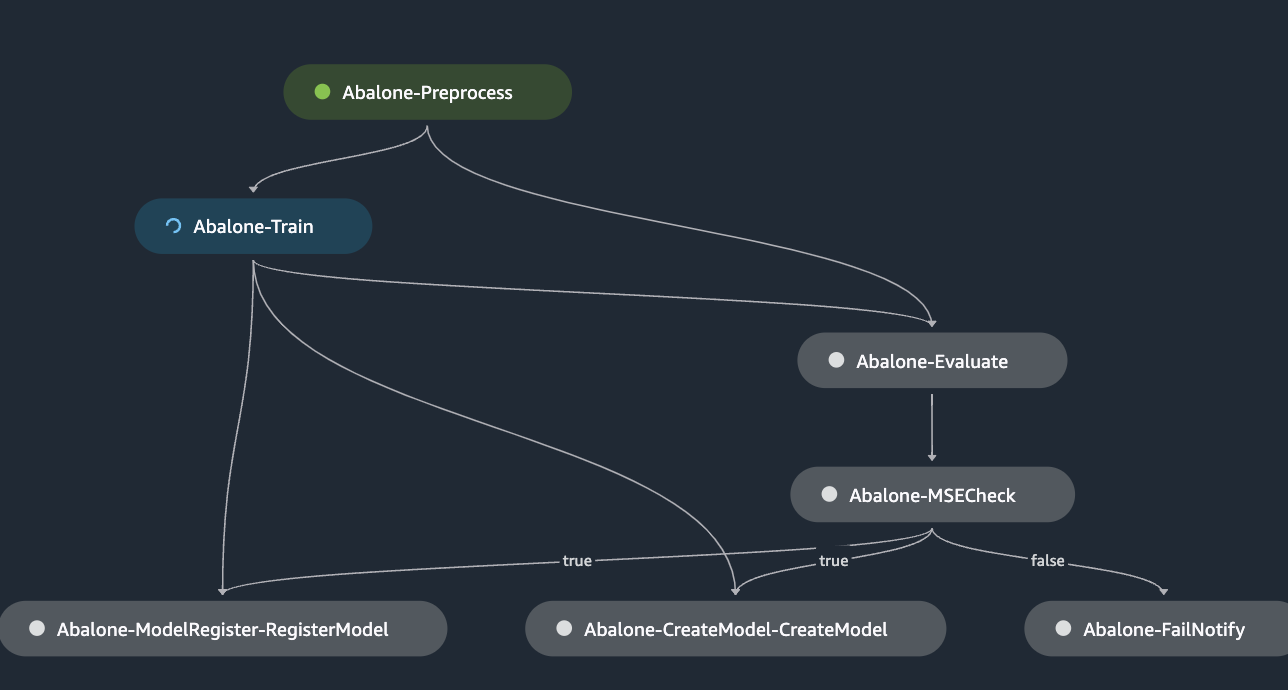

After

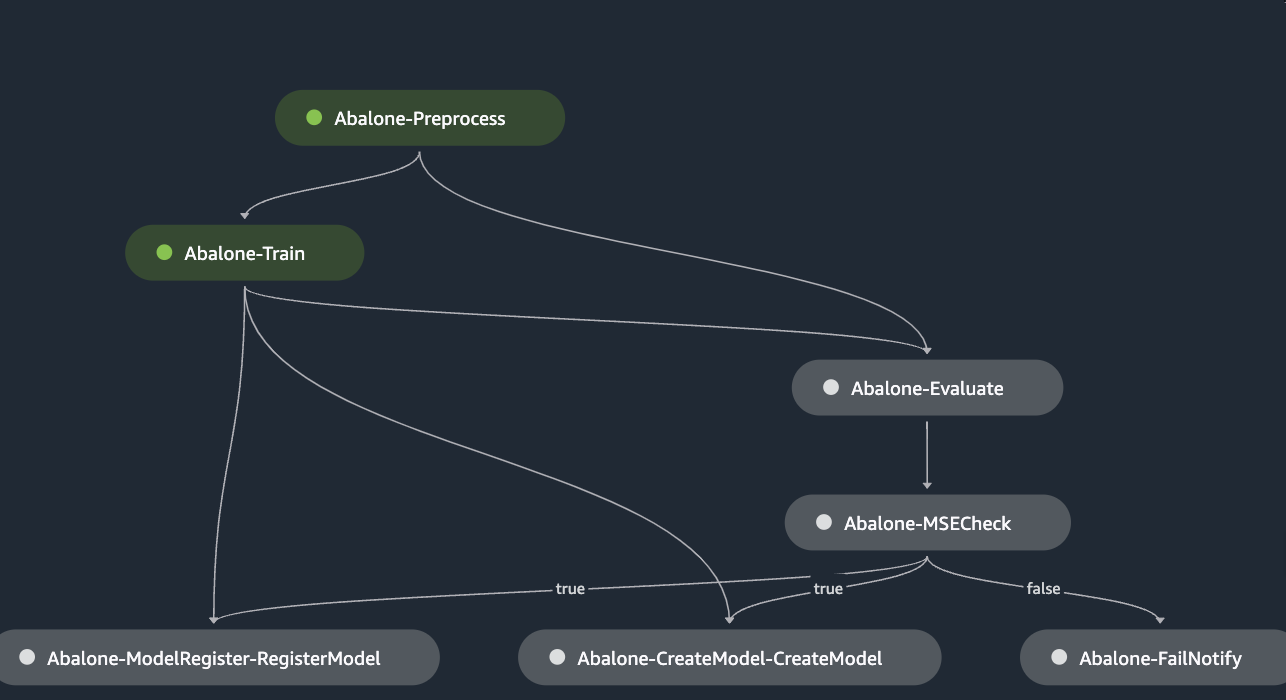

### Execute Multiple Contiguous Pipeline Steps or the Entire Pipeline Manually

In [60]:
selective_execution_config = SelectiveExecutionConfig(
    source_pipeline_execution_arn=latest_pipeline_arn,
    selected_steps=["Abalone-Train", "Abalone-Evaluate", "Abalone-MSECheck"],
)

In [61]:
select_execution = pipeline_arn.start(
    selective_execution_config=selective_execution_config,
    parameters={
        "XGBNumRounds": 120,
        "XGBSubSample": 0.9,
        "XGBGamma": 2,
        "XGBMinChildWeight": 4,
        "XGBETA": 0.25,
        "XGBMaxDepth": 12,
        "MseThreshold": 6,
    },
)

Execute Contiguous Blocks of the Pipeline


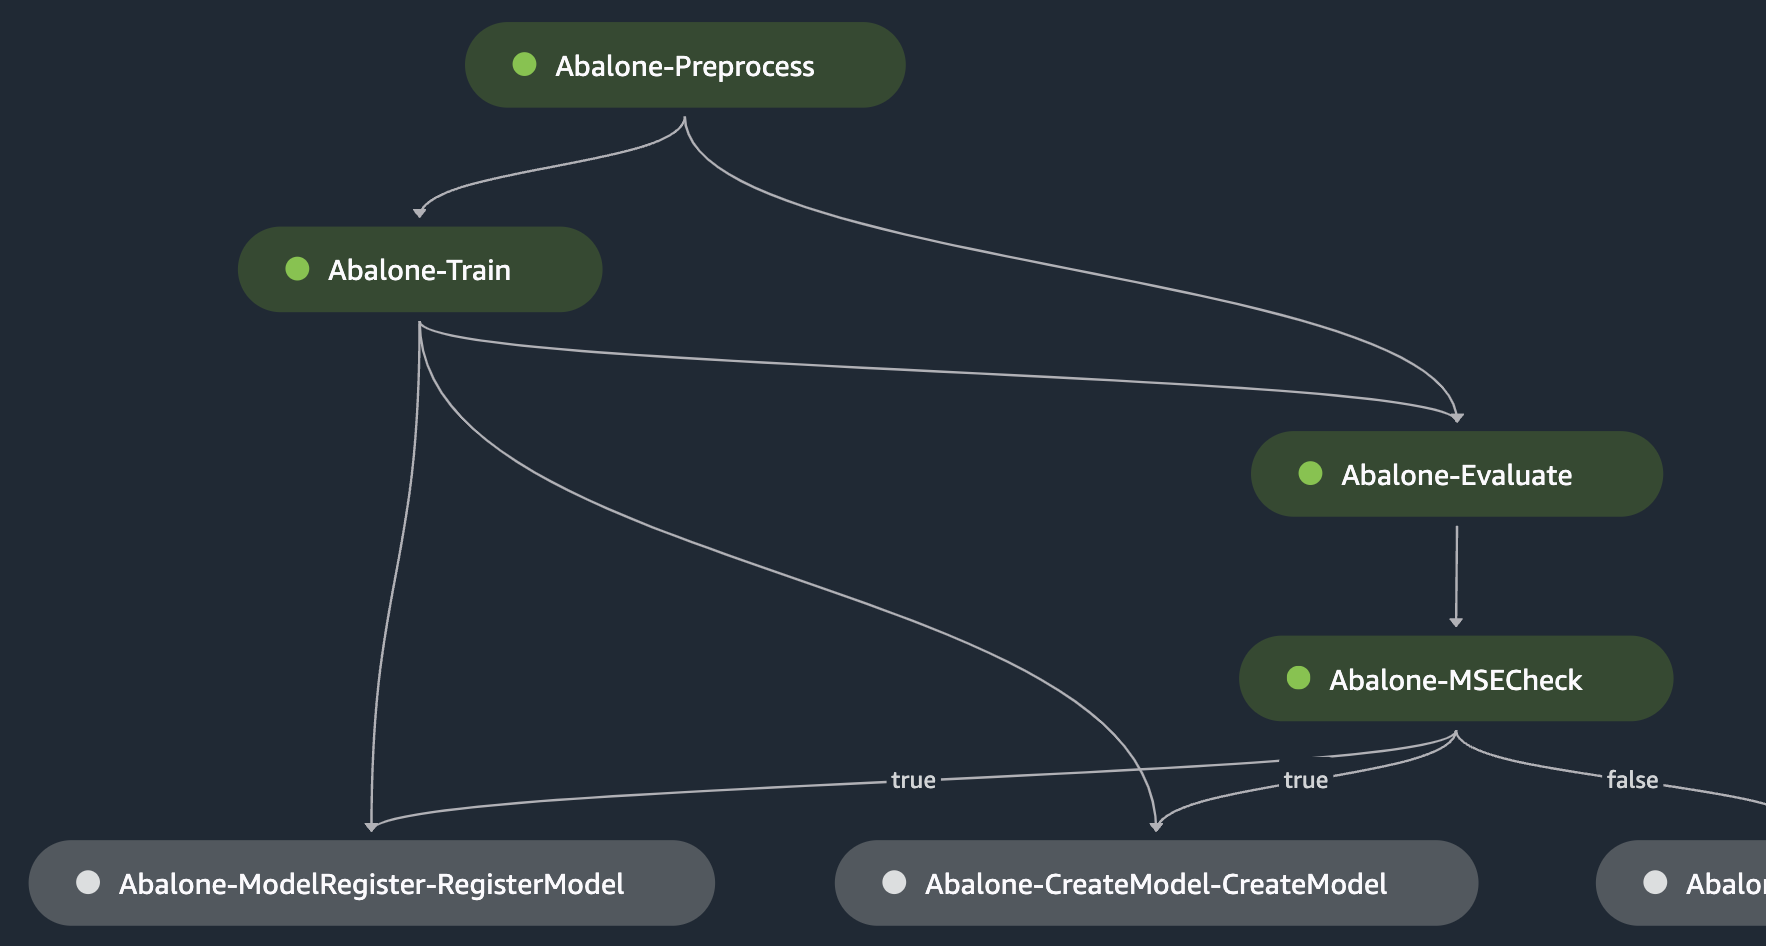


OR Execute the full pipeline 

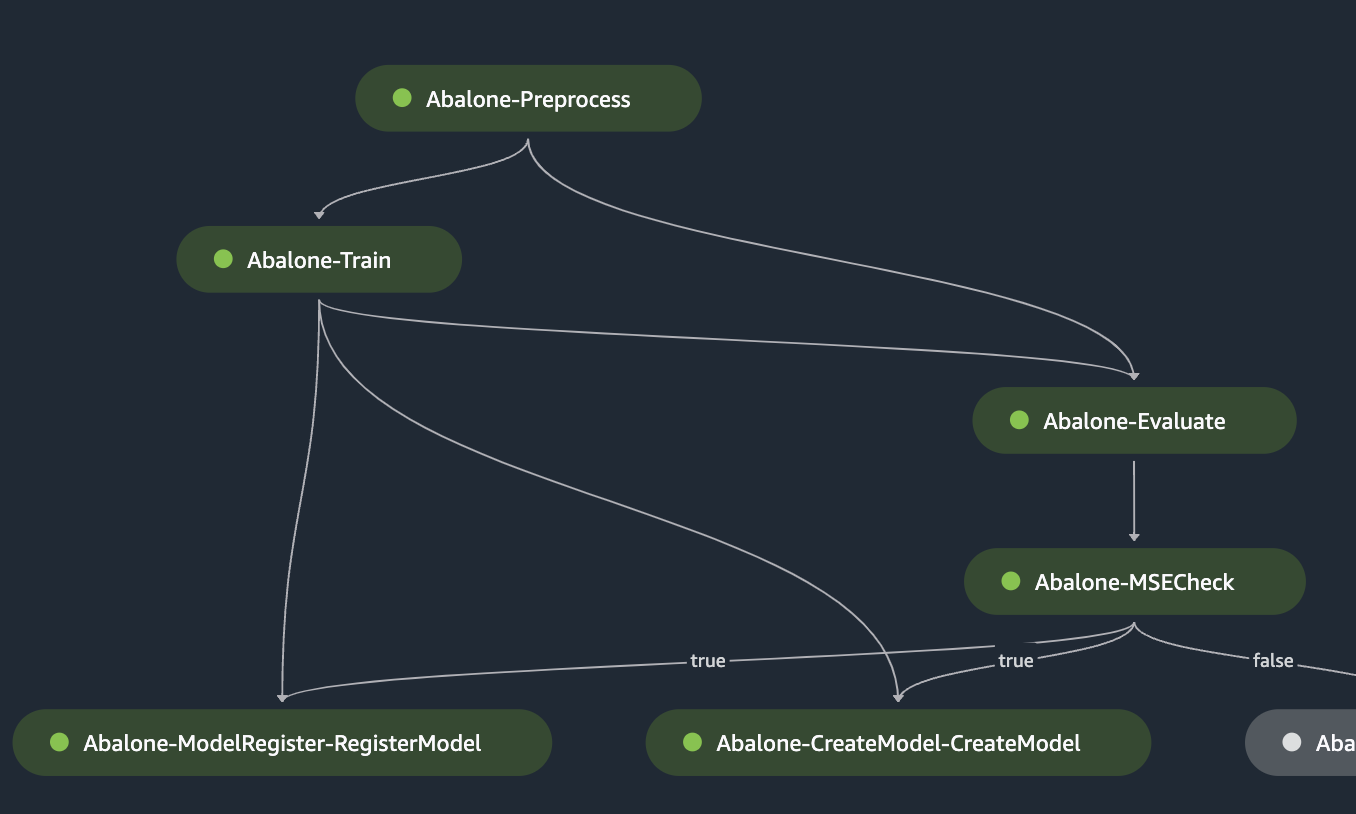

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.


![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/ml_ops|sm-pipelines_selective_execution|sm-pipelines_selective_execution.ipynb)
